# FailTech Learnig - Modelagem dos Dados
## Lucas Prado

#### Índice
[Importar Bibliotecas](#import_libraries)

[Carregar dados](#load_the_data)

[Modelagem dos dados](#modeling)
- [Configurar atributos e alvo=status_bool](#set-up)
- [Pairplot e atributos](#pairplot)
- [Distribuição dos alvos](#tar-dist)
- [Treino e teste estratificado](#split)
- [Regressão logística](#logreg1)
- [Avaliação dos modelos](#eval)
- [Conferindo outros modelos](#others)
- [Árvore de Decisão](#dt)
- [K-Nearest Neighbors](#knn)
- [Naive Bayes](#nb)
- [Máquina de Vetores de Suporte](#svm)
- [XGBoost](#xgb1)
- [Bagging](#bdt)
- [Random Forest](#rf)

[Comparação dos modelos](#modelcomp)

[Ajuste dos modelos and seleção dos atributos](#tuning)
- [Ajuste da regressão logística](#lr-tuning)
- [Ajuste do XGBoost](#xgb-tuning)

[Visualização dos Resultados](#viz)

<a class="anchor" id="import_libraries"></a>
## Importar Bibliotecas

In [219]:
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score,\
precision_recall_curve,f1_score, fbeta_score,\
accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from six import StringIO
from xgboost import XGBClassifier


import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Oswald']
font = {'size'   : 12}
plt.rc('font', **font)

%precision 5

'%.5f'

<a class="anchor" id="load_the_data"></a>
## Carregar dados

In [90]:
# Abrir um dataset já tratado
with open('/home/lucas/startup_data/clean_df.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [91]:
df.columns

Index(['permalink', 'name', 'category_list', 'funding_total_usd', 'status',
       'country_code', 'state_code', 'region', 'city', 'funding_rounds',
       'founded_at', 'first_funding_at', 'last_funding_at', 'status_bool',
       'company_name', 'avg_time_bw_rounds', 'avg_raise_usd',
       'time_bw_first_rounds', 'cat_list', 'country',
       'float_avg_time_bw_rounds', 'float_time_bw_first_rounds'],
      dtype='object')

<a class="anchor" id="modeling"></a>
## Modelagem dos dados

<a class="anchor" id="set-up"></a>
### Configurar atributos e target=status_bool

In [92]:
# Variáveis Dummies: categoria
cat_dummies = pd.get_dummies(df['cat_list'], drop_first=True)
# Variáveis Dummies: países
country_dummies = pd.get_dummies(df['country'], drop_first=True)

In [93]:
# Criar variáveis dummy para categoria e país

X_col_nodummies = [
    'funding_rounds', 'float_avg_time_bw_rounds', 'avg_raise_usd',
    'float_time_bw_first_rounds'
]
X_nodummies = df[X_col_nodummies]

In [94]:
# Fundir dummies para integrar matriz
X = X_nodummies.merge(cat_dummies, left_index=True, right_index=True).merge(
    country_dummies, left_index=True, right_index=True)

# Adicionar coluna de intercepção
X['intercept'] = 1

In [95]:
# Alvo
y = df.status_bool

In [96]:
# Exportação para visualizações
df.to_csv('/home/lucas/startup_data/df.csv')

<a class="anchor" id="pairplot"></a>
### Ver os dados sobre o pairplot, inspeccionar as interacções de atributos

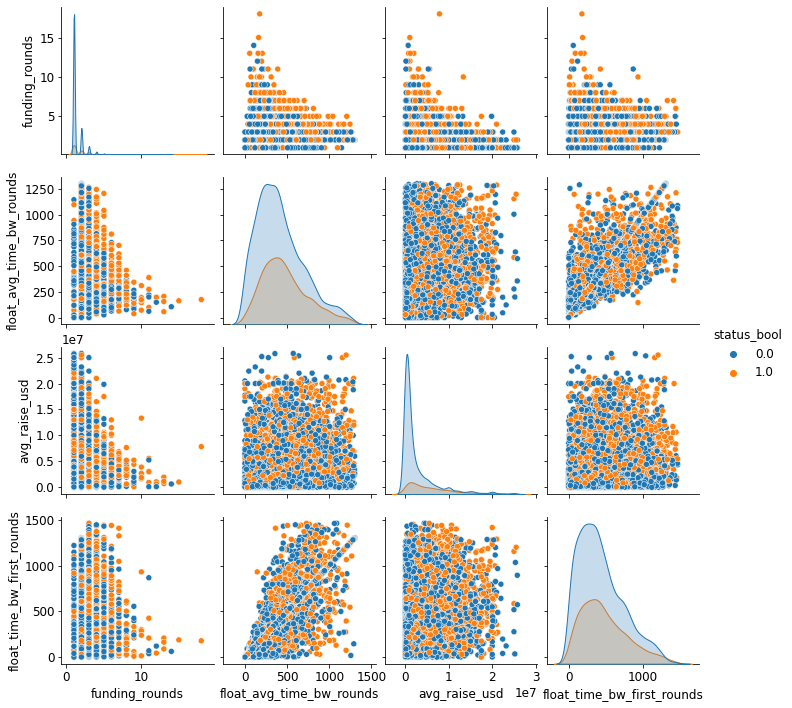

In [97]:
sns.pairplot(df[X_col_nodummies + ['status_bool']], hue='status_bool')

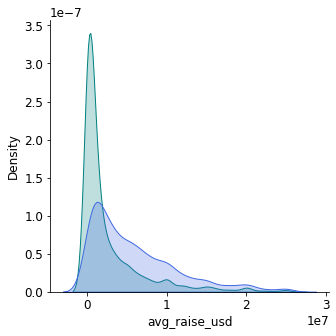

In [173]:
# Olhar mais de perto algumas das atributos

# Valor médio de acréscimo
plt.figure(figsize=(5, 5))
sns.kdeplot(df[df.status_bool == 0]['avg_raise_usd'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(df[df.status_bool == 1]['avg_raise_usd'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()
plt.savefig('/home/lucas/startup_data/avg_raise_kde.png')

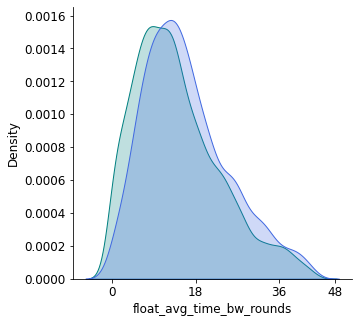

In [99]:
# Tempo médio entre as rodadas
plt.figure(figsize=(5, 5))
sns.kdeplot(df[df.status_bool == 0]['float_avg_time_bw_rounds'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(df[df.status_bool == 1]['float_avg_time_bw_rounds'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()
plt.xticks((0, 540, 1080, 1440), ('0', '18', '36', '48'))
plt.savefig('/home/lucas/startup_data/avg_time_kde.png')

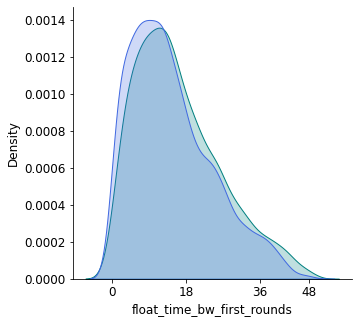

In [100]:
# Tempo médio entre as rodadas
plt.figure(figsize=(5, 5))
sns.kdeplot(df[df.status_bool == 1]['float_time_bw_first_rounds'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(df[df.status_bool == 0]['float_time_bw_first_rounds'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()
plt.xticks((0, 540, 1080, 1440), ('0', '18', '36', '48'))
plt.savefig('/home/lucas/startup_data/first_time_kde.png')

<a class="anchor" id="tar-dist"></a>
### Inspecionar a distribuição dos alvos

In [101]:
# Contar valores-alvo
target_count = y.value_counts()

# # Imprimir balanço de classes
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print('Percentage of Majority Class: {:f}'.format(
    round(target_count[0] / sum(target_count), 4) * 100))

Class 0: 24003
Class 1: 5419
Proportion: 4.43 : 1
Percentage of Majority Class: 81.580000


O conjunto de dados não apresenta grande desequilíbrio, logo não será necessário sobreamostragem da classe minoritária, porém pode ser preciso fazer uma sobreamostragem para confirmar como os resultados são afetados.

In [102]:
target_count

0.0    24003
1.0     5419
Name: status_bool, dtype: int64

<a class="anchor" id="split"></a>
### Treino estratificado + padronizar os dados

In [103]:
# Dividir os dados com 80% para treinar e 20% para testar
# Estratificar para garantir que o treino tenha um conjunto de teste
# Definir proporções semelhantes para qualquer uma das classes-alvo
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=40,
                                                    stratify=y)

In [104]:
# Padronizar os dados

scaler = StandardScaler()

# Adaptar a dimensão utilizando os dados de treinamento e escalar
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X.columns)
X_train_scaled.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dimensionar os dados de teste
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X.columns)

In [105]:
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

<a class="anchor" id="logreg1"></a>
Testar diversos algoritmos de classificação para ver quais têm melhor desempenho e depois tentar optimizar os melhores, ajustando os seus hiperparâmetros, bem como a selecção de atributos e qualquer engenharia de atributos adicionais.
### Regressão logística

In [180]:
# Modelo instantâneo
logreg = LogisticRegression(C=10, solver='lbfgs')

# Adaptar o modelo aos dados de treinamento
logreg.fit(X_train_scaled, y_train)

# Guardar isso para ser utilizado depois
joblib.dump(logreg, 'logreg.pkl')

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


['logreg.pkl']

In [107]:
# Calcular curva ROC para regressão logística
fpr_lr, tpr_lr, thresholds_lr = roc_curve(
    y_test,
    logreg.predict_proba(X_test_scaled)[:, 1])

# Calcular área sob a curva (AUC) para ROC
auc_lr = roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1])

<a class="anchor" id="eval"></a>
### Avaliando os Modelos

#### Calculando f_beta
Os pesos da pontuação F-beta recuperam mais do que a precisão por um factor de beta.

No caso de investimentos de capital de risco se atribuiu peso maior a recuperação do que a precisão porque é pior perder um potencial investimento em unicórnio (10-100X retorno) (erro tipo II - falso negativo) do que investir uma "dud" (1X perda) (erro tipo 1 - falso positivo). 

No entanto, não foi colocado todo o peso na recuperação, uma vez que ainda é valioso para uma empresa de capital de risco distinguir-se, reduzindo a quantidade de "duds" em que investe.

Na perspectiva de um fundador, eles dariam prioridade à precisão, uma vez que iniciar uma startup requer muito tempo e esforço, eles querem realmente melhorar a probabilidade de iniciar uma empresa de sucesso e evitar falhas.

Por isso é imporatnte encontrar o limiar de probabilidade que optimiza a pontuação f_beta.

In [108]:
def fbeta(model, y_test=y_test, X_test=X_test_scaled):
    """
    Calculate the probability threshold that yields the highest f_beta value
    input: fitted model, y_test, X_test
    """
    prob_thresholds = np.arange(0, 1, 0.005)
    fbeta = []
    for prob in prob_thresholds:
        fbeta.append(
            fbeta_score(y_test,
                        model.predict_proba(X_test)[:, 1] > prob, 3))
    all_fbeta = list(zip(prob_thresholds, fbeta))
    best_fbeta = max(list(zip(prob_thresholds, fbeta)), key=lambda x: x[1])
    print(
        'Probability that yields the best fbeta score is {} with fbeta={:5f}'.
        format(best_fbeta[0], best_fbeta[1]))
    return all_fbeta, best_fbeta

In [109]:
# Calcular fbeta para regressão logística
all_fbeta_lr, best_fbeta_lr = fbeta(logreg, X_test=X_test_scaled)
p_thresh = best_fbeta_lr[0]

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

Probability that yields the best fbeta score is 0.07 with fbeta=0.710490


/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

#### Precisão da curva de recuperação (com f_beta)

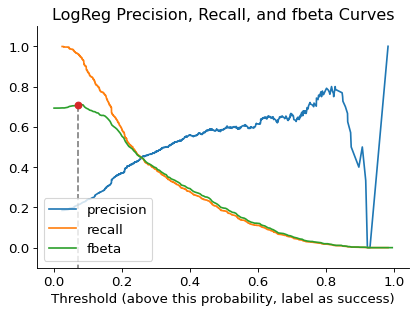

In [110]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_test,
    logreg.predict_proba(X_test_scaled)[:, 1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(list(zip(*all_fbeta_lr))[0],
         list(zip(*all_fbeta_lr))[1],
         label='fbeta')
plt.plot([best_fbeta_lr[0], best_fbeta_lr[0]], [-1, best_fbeta_lr[1]],
         '--',
         color='black',
         alpha=0.5)
plt.plot(best_fbeta_lr[0], best_fbeta_lr[1], 'o')
plt.ylim([-0.1, 1.1])
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as success)')
plt.title('LogReg Precision, Recall, and fbeta Curves')
sns.despine()
plt.savefig('/home/lucas/startup_data//init_lr_precisionrecallcurve.png')
plt.savefig('/home/lucas/startup_data//init_lr_precisionrecallcurve.svg')

In [111]:
lr_coefs = list(zip(X.columns, logreg.coef_[0]))
lr_coefs_df = pd.DataFrame(lr_coefs)
lr_top_coefs = [x for x in lr_coefs if np.abs(x[1]) > .07]
lr_top_coefs = sorted(lr_top_coefs, key=(lambda x: x[1]), reverse=True)
lr_top_coefs_df = pd.DataFrame(lr_top_coefs)
lr_top_coefs_df.to_csv('/home/lucas/startup_data/lr_coefs.csv')

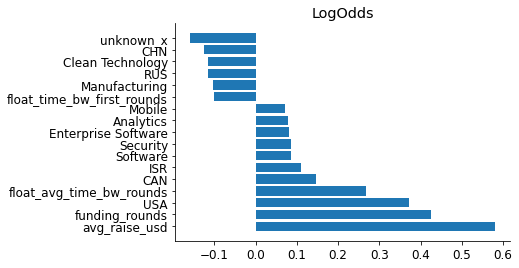

In [112]:
plt.barh([x[0] for x in lr_top_coefs], width=[x[1] for x in lr_top_coefs])
plt.title('LogOdds')
plt.grid(b=False)
sns.despine()

<a class="anchor" id="others"></a>
## Conferindo outros modelos
<a class="anchor" id="dt"></a>
### Árvore de decisão
Semelhante à regressão logística, a árvore de decisão é muito fácil de interpretar, por isso, esta será outra forma de olhar para a importância das atributos.

A árvore de decisão não requer que os dados sejam dimensionados.

In [290]:
dt = DecisionTreeClassifier(max_depth=5)
X_train = pd.DataFrame(np.nan_to_num(X_train))
X_test = pd.DataFrame(np.nan_to_num(X_test))
y_train = pd.DataFrame(np.nan_to_num(y_train))
dt.fit(X_train, y_train)

# Calcular fbeta para árvore de decisão
all_fbeta_dt, best_fbeta_dt = fbeta(dt,
                                    X_test=X_test)  # não dimensionado para dt

# Calcular a pontuação ROC e AUC para árvore de decisão
fpr_dt, tpr_dt, thresholds_dt = roc_curve(
    y_test,
    dt.predict_proba(X_test)[:, 1])  # não dimensionado para dt
auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

Probability that yields the best fbeta score is 0.035 with fbeta=0.710542


/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

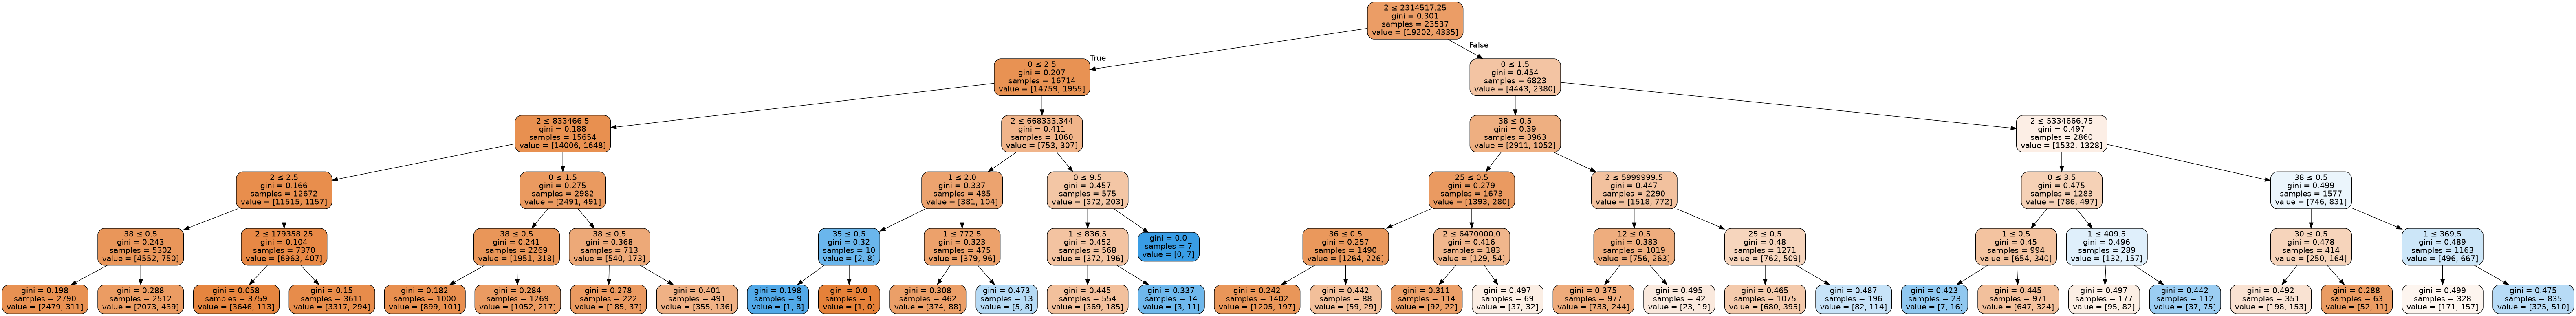

In [291]:
# Criar uma árvore de decisão de forma simples.
dot_data = StringIO()
export_graphviz(dt,
                out_file=dot_data,
                feature_names=X_train.columns.tolist(),
                filled=True,
                rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/home/lucas/startup_data/decision_tree.png')
Image(graph.create_png())

Azul é 1, vermelho é 0

In [174]:
# Importância das atributos

pd.DataFrame({
    'feature': X.columns,
    'importance': dt.feature_importances_
}).sort_values(by='importance', ascending=False)[0:15]

,feature,importance
2,avg_raise_usd,0.622446
0,funding_rounds,0.217917
38,USA,0.088082
1,float_avg_time_bw_rounds,0.034494
25,Software,0.020378
30,CHN,0.006782
36,ISR,0.005503
12,Enterprise Software,0.003075
35,IND,0.001323
29,CAN,0.000000


<a class="anchor" id="knn"></a>
### KNN
Enquanto a KNN requer quase nenhum tempo treinar, leva muito tempo para construir previsões e é utilizada com menos frequência do que outros classificadores. Dito isto, este projeto é um exercício de compreensão dos vários algoritmos de classificação, pelo que é utilizado abaixo para a sua exaustividade.

In [126]:
# Modelo Instantâneo
knn = KNeighborsClassifier(n_neighbors=5)

# Modelo de ajuste
knn.fit(X_train_scaled, y_train)

/home/lucas/.local/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [127]:
# Calcular fbeta para KNN
all_fbeta_knn, best_fbeta_knn = fbeta(knn,
                                      X_test=X_test_scaled)  # dimensionado para knn

# Calcular a pontuação ROC e AUC para KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(
    y_test,
    knn.predict_proba(X_test_scaled)[:, 1])  # dimensionado para knn
auc_knn = roc_auc_score(
    y_test,
    knn.predict_proba(X_test_scaled)[:, 1])  # dimensionado para knn

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

Probability that yields the best fbeta score is 0.0 with fbeta=0.631736


<a class="anchor" id="nb"></a>
### Naive Bayes
#### Bernoulli
Este classificador funciona melhor em atributos binárias

In [128]:
nbb = BernoulliNB()
nbb.fit(X_train_scaled, y_train)

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


BernoulliNB()

In [129]:
# Calcular fbeta para Naive Bayes Bernoulli
all_fbeta_nbb, best_fbeta_nbb = fbeta(nbb,
                                      X_test=X_test_scaled)  # dimensionado para nbb

# Calcular a pontuação ROC e AUC para Naive Bayes Bernoul
fpr_nbb, tpr_nbb, thresholds_nbb = roc_curve(
    y_test,
    nbb.predict_proba(X_test_scaled)[:, 1])  # dimensionado para nbb
auc_nbb = roc_auc_score(
    y_test,
    nbb.predict_proba(X_test_scaled)[:, 1])  # dimensionado para nbb

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

Probability that yields the best fbeta score is 0.02 with fbeta=0.700518


/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


#### Gaussiana
Este modelo de classificação funciona melhor com atributos constantes

In [130]:
nbg = GaussianNB()
nbg.fit(X_train_scaled, y_train)

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GaussianNB()

In [131]:
# Calcular fbeta para Naive Bayes Gaussian
all_fbeta_nbg, best_fbeta_nbg = fbeta(nbg,
                                      X_test=X_test_scaled)  # dimensionado para nbg

# Calcular a pontuação ROC e AUC para Naive Bayes Gaussian
fpr_nbg, tpr_nbg, thresholds_nbg = roc_curve(
    y_test,
    nbg.predict_proba(X_test_scaled)[:, 1])  # dimensionado para nbg
auc_nbg = roc_auc_score(
    y_test,
    nbg.predict_proba(X_test_scaled)[:, 1])  # dimensionado para nbg

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

Probability that yields the best fbeta score is 0.0 with fbeta=0.693050


/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

NOTA: Multinomial Naive Bayes não foram testados - este classificador funciona melhor com atributos baseados em contagem - apenas uma das atributos presentes no conjuntos de dados é baseada na contagem (número de rodadas) - este algoritmo não pode lidar com dados negativos.

<a class="anchor" id="svm"></a>

### Máquina de Vetores de Suporte

In [132]:
svm_model = svm.SVC(kernel="linear", probability=True)
svm_model.fit(X_train_scaled, y_train)

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(kernel='linear', probability=True)

In [133]:
# Calcular fbeta para MVS
all_fbeta_svm_model, best_fbeta_svm_model = fbeta(
    svm_model, X_test=X_test_scaled)  # dimensionado para MVS

# Calcular a pontuação ROC e AUC para MVS
fpr_svm_model, tpr_svm_model, thresholds_svm_model = roc_curve(
    y_test,
    svm_model.predict_proba(X_test_scaled)[:, 1])  # dimensionado para MVS
auc_svm_model = roc_auc_score(
    y_test,
    svm_model.predict_proba(X_test_scaled)[:, 1])  # dimensionado para MVS

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

Probability that yields the best fbeta score is 0.0 with fbeta=0.693050


<a class="anchor" id="xgb1"></a>
### XGBoost
Semelhante a outros algoritmos baseados em árvores, mas utiliza o boosting para calcular cada árvore subsequente, que é necessariamente sequencial e, portanto, demora mais tempo para executar.

In [134]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

/home/lucas/.local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[22:47:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [135]:
# Calcular fbeta para XGBoost
prob_thresholds = np.arange(0, 1, 0.005)
fbeta_xgb = []
for prob in prob_thresholds:
    fbeta_xgb.append(
        fbeta_score(y_test,
                    xgb.predict_proba(X_test)[:, 1] > prob, 3))
all_fbeta_xgb = list(zip(prob_thresholds, fbeta_xgb))
best_fbeta_xgb = max(list(zip(prob_thresholds, fbeta_xgb)), key=lambda x: x[1])
print('Probability that yields the best fbeta score is {} with fbeta={:5f}'.
      format(best_fbeta_xgb[0], best_fbeta_xgb[1]))

# Calcular a pontuação ROC e AUC para Naive Bayes Gaussian
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(
    y_test,
    xgb.predict_proba(X_test)[:, 1])  # não dimensionado para xgboost
auc_xgb = roc_auc_score(
    y_test,
    xgb.predict_proba(X_test)[:, 1])  # não dimensionado para xgboost

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

Probability that yields the best fbeta score is 0.06 with fbeta=0.717908


In [136]:
xgb_feats = sorted(list(zip(X.columns, xgb.feature_importances_)),
                   key=(lambda x: x[1]),
                   reverse=True)

<a class="anchor" id="bdt"></a>
### Bagging
Série de árvores de decisão que utilizam amostras a partir do conjunto de treino.

In [137]:
bag_dt = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=500,
                           bootstrap=True,
                           oob_score=True,
                           random_state=1234,
                           n_jobs=-1)
# Ajuste
bag_dt.fit(X_train, y_train)

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True, random_state=1234)

In [138]:
# Calcular fbeta para Bagging
all_fbeta_bag_dt, best_fbeta_bag_dt = fbeta(
    bag_dt, X_test=X_test)  # não dimensionado para bag_dt

# Calcular ROC Score e AUC para Bagging
fpr_bag_dt, tpr_bag_dt, thresholds_bag_dt = roc_curve(
    y_test,
    bag_dt.predict_proba(X_test)[:, 1])  # não dimensionado para bag dt
auc_bag_dt = roc_auc_score(
    y_test,
    bag_dt.predict_proba(X_test)[:, 1])  # não dimensionado para bag dt

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

Probability that yields the best fbeta score is 0.0 with fbeta=0.699724


<a class="anchor" id="rf"></a>
### Random Forest
Similar ao Bagging com árvores de decisão, porém a cada estratificação em uma árvore apenas um subconjunto do número total de atributos é considerado, introduzindo assim mais aleatoriedade e ajudando a montar as árvores.

In [139]:
# Modelo Instantâneo
rf = RandomForestClassifier(n_estimators=500,
                            bootstrap=True,
                            oob_score=True,
                            random_state=1234,
                            n_jobs=-1)

# Ajuste
rf.fit(X_train, y_train)

<ipython-input-139-b3c3c12610b6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=1234)

In [140]:
# Calcular fbeta para Random Forest
all_fbeta_rf, best_fbeta_rf = fbeta(rf, X_test=X_test)  # não dimensionado para rf

# Calcular ROC Score e AUC para Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    y_test,
    rf.predict_proba(X_test)[:, 1])  # not scaled for rf
auc_rf = roc_auc_score(y_test,
                       rf.predict_proba(X_test)[:, 1])  # não dimensionado para rf

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

Probability that yields the best fbeta score is 0.0 with fbeta=0.701458


In [175]:
# Relevância dos atributos
rf_feats = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Ranking dos principais atributos (TOP 10)
rf_feats[0:10]

,feature,importance
2,avg_raise_usd,0.481824
1,float_avg_time_bw_rounds,0.125704
3,float_time_bw_first_rounds,0.123818
0,funding_rounds,0.057164
38,USA,0.022984
25,Software,0.011906
20,Mobile,0.010893
7,Biotechnology,0.009822
9,Curated Web,0.008024
12,Enterprise Software,0.007860


<a class="anchor" id="modelcomp"></a>
## Comparação dos modelos

In [142]:
models = ['lr', 'dt', 'knn', 'nbb', 'nbg', 'svm', 'xgb', 'bag_dt', 'rf']
model_aucs = [
    auc_lr, auc_dt, auc_knn, auc_nbb, auc_nbg, auc_svm_model, auc_xgb,
    auc_bag_dt, auc_rf
]
model_fbetas = [
    best_fbeta_lr[1], best_fbeta_dt[1], best_fbeta_knn[1], best_fbeta_nbb[1],
    best_fbeta_nbg[1], best_fbeta_svm_model[1], best_fbeta_xgb[1],
    best_fbeta_bag_dt[1], best_fbeta_rf[1]
]
model_names = [
    'Logistic Regression', 'Decision Tree', 'KNN', 'Bernoulli Naive Bayes',
    'Gaussian Naive Bayes', 'Support Vector Machine', 'XGBoost',
    'Bagged Decision Tree', 'Random Forest'
]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Oswald


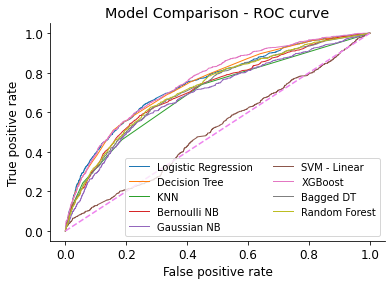

In [143]:
# Plotar curvas ROC

plt.plot(fpr_lr, tpr_lr, lw=1, label='Logistic Regression')
plt.plot(fpr_dt, tpr_dt, lw=1, label='Decision Tree')
plt.plot(fpr_knn, tpr_knn, lw=1, label='KNN')
plt.plot(fpr_nbb, tpr_nbb, lw=1, label='Bernoulli NB')
plt.plot(fpr_nbg, tpr_nbg, lw=1, label='Gaussian NB')
plt.plot(fpr_svm_model, tpr_svm_model, lw=1, label='SVM - Linear')
plt.plot(fpr_xgb, tpr_xgb, lw=1, label='XGBoost')
plt.plot(fpr_bag_dt, tpr_bag_dt, lw=1, label='Bagged DT')
plt.plot(fpr_rf, tpr_rf, lw=1, label='Random Forest')

plt.plot([0, 1], [0, 1], c='violet', ls='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Model Comparison - ROC curve')
plt.legend(ncol=2, fontsize='small')
sns.despine()
plt.savefig('/home/lucas/startup_data/model_comp_roc.svg')
plt.savefig('/home/lucas/startup_data/model_comp_roc.png')

In [144]:
# Print AUC Scores
for model in list(zip(model_names, model_aucs)):
    print("ROC AUC score = {:3f} for {}".format(model[1], model[0]))

ROC AUC score = 0.745291 for Logistic Regression
ROC AUC score = 0.744486 for Decision Tree
ROC AUC score = 0.691408 for KNN
ROC AUC score = 0.711981 for Bernoulli Naive Bayes
ROC AUC score = 0.691350 for Gaussian Naive Bayes
ROC AUC score = 0.511771 for Support Vector Machine
ROC AUC score = 0.755675 for XGBoost
ROC AUC score = 0.715033 for Bagged Decision Tree
ROC AUC score = 0.719686 for Random Forest


In [145]:
# Print fbeta Scores
for model in list(zip(model_names, model_fbetas)):
    print("f_beta score = {:3f} for {}".format(model[1], model[0]))

f_beta score = 0.710490 for Logistic Regression
f_beta score = 0.710542 for Decision Tree
f_beta score = 0.631736 for KNN
f_beta score = 0.700518 for Bernoulli Naive Bayes
f_beta score = 0.693050 for Gaussian Naive Bayes
f_beta score = 0.693050 for Support Vector Machine
f_beta score = 0.717908 for XGBoost
f_beta score = 0.699724 for Bagged Decision Tree
f_beta score = 0.701458 for Random Forest


O melhor desempenho é percebido com o classificador XGBoost. Vamos aperfeiçoar este modelo, bem como a Regressão Logística, que também teve um bom desempenho e é altamente interpretável para reduzir a lista de atributos e otimizar o poder preditivo dos modelos.

<a class="anchor" id="tuning"></a>
## Ajuste dos modelos e seleção de atributos

Pegar os modelos que tiveram o melhor desempenho e ajustar seus hiperparâmetros para melhorar ainda mais o desempenho.
Para a regressão logística, se utiliza a regularização para reduzir a lista de atributos.
Para modelos baseados em árvores, é verificada a importância de cada atributo para selecionar os atributos mais importantes.

<a class="anchor" id="lr-tuning"></a>
### Ajuste de Regressão Logística
Primeiro - olhar para o modelo de regressão logística - tentar otimizar seus hiperparâmetros e experimentar a regularização para avaliar a importância dos atributos e a colinearidade dos atributos.

Tentar executar um modelo com alta regularização para ver quais coeficientes vão a zero.

In [176]:
lr_reg = LogisticRegression(solver='saga',
                            C=0.1,
                            penalty='elasticnet',
                            l1_ratio=0.95)
lr_reg.fit(X_train_scaled, y_train)

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=0.1, l1_ratio=0.95, penalty='elasticnet', solver='saga')

In [177]:
# Observar os coeficientes
lr_reg_coefs = pd.DataFrame(sorted(list(zip(X.columns, lr_reg.coef_[0])),
                                   key=(lambda x: x[1]),
                                   reverse=True),
                            columns=['Feature', 'Coefficient'])
lr_reg_coefs

,Feature,Coefficient
0,avg_raise_usd,0.575712
1,funding_rounds,0.423684
2,USA,0.363391
3,float_avg_time_bw_rounds,0.216468
4,CAN,0.141821
5,ISR,0.106479
6,Software,0.086255
7,Security,0.084431
8,Enterprise Software,0.079392
9,Analytics,0.077324


Há muitos atributos com coeficientes realmente baixos ou zero - com isso é possível simplificar o modelo, mantendo apenas os atributos importantes sem custo de desempenho do modelo.

In [178]:
# Selecionar apenas atributos com coeficientes fortes
X_sel_cols = list(lr_reg_coefs[abs(lr_reg_coefs['Coefficient']) > 0.05]
                  ['Feature'])  # Manter apenas atributos com coeficientes mais altos
X_sel_cols.append('Mobile')
X_sel_cols.append('Advertising')
X_sel_cols.append('Finance')
X_sel_cols.append('intercept')

In [179]:
# Salvar nomes de colunas
joblib.dump(X_sel_cols, 'X_sel_cols.pkl')

['X_sel_cols.pkl']

In [152]:
X_sel_cols_reorder = [
    'funding_rounds', 'float_time_bw_first_rounds', 'float_avg_time_bw_rounds',
    'avg_raise_usd', 'Advertising', 'Apps', 'Biotechnology',
    'Clean Technology', 'Education', 'Enterprise Software', 'Finance',
    'Hardware + Software', 'Manufacturing', 'Mobile', 'Software', 'CAN', 'CHN',
    'ISR', 'RUS', 'USA', 'intercept'
]

In [153]:
X_sel = X[X_sel_cols_reorder]

In [154]:
# Dividir os dados com 80% para treinar e 20% para testar
# Estratificar para garantir que o treinamento tenha um conjuntos de teste 
# Definir proporções semelhantes para qualquer uma das classes-alvo
X_sel_train, X_sel_test, y_sel_train, y_sel_test = train_test_split(
    X_sel, y, test_size=0.2, random_state=40, stratify=y)

In [155]:
# Padronizar os dados com novo redimensionamento para colunas selecionadas

scaler_sel = StandardScaler()
scaler_sel.fit(X_sel_train.values)
# Guardar para utilizar depois
# joblib.dump(scaler_sel,'scaler_sel.pkl');
with open("scaler_sel.pkl", "wb") as f:
    pickle.dump(scaler_sel, f)

In [156]:
# Adaptar as dimensões usando os dados de treinamento e dimensionar
X_sel_train_scaled = pd.DataFrame(scaler_sel.transform(X_sel_train.values),
                                  columns=X_sel_cols_reorder)

# Dimensionar os dados de teste
X_sel_test_scaled = pd.DataFrame(scaler_sel.transform(X_sel_test.values),
                                 columns=X_sel_cols_reorder)

In [157]:
X_sel.columns

Index(['funding_rounds', 'float_time_bw_first_rounds',
       'float_avg_time_bw_rounds', 'avg_raise_usd', 'Advertising', 'Apps',
       'Biotechnology', 'Clean Technology', 'Education', 'Enterprise Software',
       'Finance', 'Hardware + Software', 'Manufacturing', 'Mobile', 'Software',
       'CAN', 'CHN', 'ISR', 'RUS', 'USA', 'intercept'],
      dtype='object')

In [190]:
scaler_sel.transform(np.array(list(X_sel_test.iloc[1].values)).reshape(1, -1))

array([[ 0.59971,  1.04023,  1.16499,  3.31182, -0.16812, -0.05949,
        -0.26761, -0.16132, -0.13802, -0.1958 , -0.14259,  6.6662 ,
        -0.1415 , -0.30723, -0.37935, -0.16932, -0.15824, -0.12161,
        -0.10085,  0.8777 ,  0.     ]])

In [288]:
# Tentar valores diferentes para C
c_vals = np.arange(0.1, 1.5, 0.1)

paramgrid = {'C': c_vals, 'penalty': ['l1', 'l2']}

# Definir parâmetros de dobra
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [292]:
# Modelo instantâneo
lr_sel = GridSearchCV(LogisticRegression(solver='saga'),
                      paramgrid,
                      cv=kf,
                      scoring='recall')

# Adaptar o modelo aos dados de treinamento
X_sel_train_scaled = pd.DataFrame(np.nan_to_num(X_sel_train_scaled))
y_sel_train = pd.DataFrame(np.nan_to_num(y_sel_train))
lr_sel.fit(X_sel_train_scaled, y_sel_train)

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(solver='saga'),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4]),
                         'penalty': ['l1', 'l2']},
             scoring='recall')

In [293]:
# Sintonize os parâmetros dos modelos
lr_tuned = lr_sel.best_estimator_
lr_tuned

LogisticRegression(C=0.4, penalty='l1', solver='saga')

In [294]:
lr_sel.fit(X_sel_train_scaled, y_sel_train)

# Calcular área sob a curva (AUC) para ROC
auc_lr_sel = roc_auc_score(y_sel_test,
                           lr_tuned.predict_proba(X_sel_test_scaled)[:, 1])
# Calcular a fbeta
fbeta(lr_tuned, X_test=X_sel_test_scaled)

print('AUC = {}'.format(auc_lr_sel))

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

Probability that yields the best fbeta score is 0.065 with fbeta=0.705386
AUC = 0.7356360644422941


/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass beta=3 as keyword args. From version 1.0

O desempenho da Regressão Logística melhorou ligeiramente na pontuação da AUC.

### Salvar Modelo de Regressão Logística para aplicações

In [295]:
# Criar um atributo para os nomes dos recursos
lr_tuned.feature_names = X_sel.columns
lr_tuned.target_names = ['Fail', 'Success']

In [296]:
X_sel.columns

Index(['funding_rounds', 'float_time_bw_first_rounds',
       'float_avg_time_bw_rounds', 'avg_raise_usd', 'Advertising', 'Apps',
       'Biotechnology', 'Clean Technology', 'Education', 'Enterprise Software',
       'Finance', 'Hardware + Software', 'Manufacturing', 'Mobile', 'Software',
       'CAN', 'CHN', 'ISR', 'RUS', 'USA', 'intercept'],
      dtype='object')

In [297]:
lr_tuned.feature_display_names = [
    'Number of Funding Rounds', 'Time Between First Rounds (months)',
    'Average Time Between Rounds (months)', 'Average Raise Amount ($)',
    'Advertising', 'Apps', 'Biotechnology', 'Clean Technology', 'Education',
    'Enterprise Software', 'Finance', 'Hardware + Software', 'Manufacturing',
    'Mobile', 'Software', 'Canada', 'China', 'Israel', 'Russia',
    'United States', 'int']

In [298]:
# Guardar para utilizar depois
with open("lr_tuned.pkl", "wb") as f:
    pickle.dump(lr_tuned, f)

#### Interpretanto Coeficientes e Interceptando

In [299]:
# Interceptar
lr_sel.fit(X_sel_train_scaled, y_sel_train)
lr_tuned.intercept_[0]

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

-1.7053882750088842

In [300]:
# Converter log-odds de interceptação em probabilidade
lr_sel.fit(X_sel_train_scaled, y_sel_train)
logodds = lr_tuned.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob[0]
print(
    'All else considered, companies that make it past their\
    first funding round, probability of success is {:.2f}%'
    .format(100 * prob[0]))

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

All else considered, companies that make it past their    first funding round, probability of success is 15.38%


/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

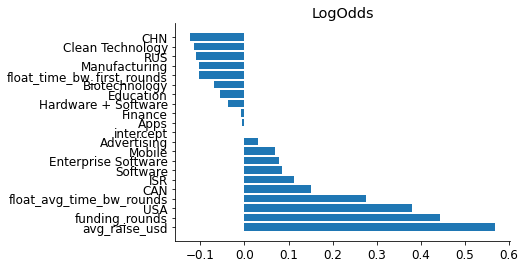

In [301]:
lr_sel.fit(X_sel_train_scaled, y_sel_train)
lr_tuned_coefs = pd.DataFrame(sorted(list(zip(X_sel.columns,
                                              lr_tuned.coef_[0])),
                                     key=(lambda x: x[1]),
                                     reverse=True),
                              columns=['Feature', 'Coefficient'])
lr_tuned_coefs['Odds'] = np.exp(lr_tuned_coefs.Coefficient)

# Plotar coeficientes
plt.barh(lr_tuned_coefs['Feature'], width=lr_tuned_coefs['Coefficient'])
plt.title('LogOdds')
plt.grid(b=False)
sns.despine()

# Salvar coeficientes
with open("lr_tuned_coefs.pkl", "wb") as f:
    pickle.dump(lr_tuned_coefs, f)

In [304]:
df['float_time_bw_first_rounds'].std()

306.4568756794417

In [305]:
lr_sel.fit(X_sel_train_scaled, y_sel_train)
lr_tuned_coefs

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

,Feature,Coefficient,Odds
0,avg_raise_usd,0.567175,1.763279
1,funding_rounds,0.442455,1.556524
2,USA,0.380840,1.463513
3,float_avg_time_bw_rounds,0.275926,1.317750
4,CAN,0.151749,1.163868
5,ISR,0.112586,1.119168
6,Software,0.084409,1.088074
7,Enterprise Software,0.078793,1.081981
8,Mobile,0.068369,1.070761
9,Advertising,0.030060,1.030517


<a class="anchor" id="xgb-tuning"></a>
### Ajuste no XGBoost
Espera-se otimizar n_estimadores e max_features e restringir a seleção de recursos, mantendo os atributos com valores de importância não zero da linha de base XGB mdoel

In [306]:
X_sel_cols_xgb = [feat[0] for feat in xgb_feats if feat[1] > 0]

# Salvar nomes das colunas
joblib.dump(X_sel_cols_xgb, 'X_sel_cols_xgb.pkl')

# Criar nova matriz de atributos
X_sel_xgb = X[X_sel_cols_xgb]

In [307]:
# Dividir os dados com 80% para treinar e 20% para testar
# Estratificar para garantir que o treinamento tenha um conjuntos de teste 
# Definir proporções semelhantes para qualquer uma das classes-alvo
X_sel_xgb_train, X_sel_xgb_test, y_sel_xgb_train, y_sel_xgb_test = train_test_split(
    X_sel_xgb, y, test_size=0.2, random_state=40, stratify=y)


Configurar hiperparâmetros para encontrar o modelo com o melhor desempenho.

In [308]:
paramgrid = {
    'n_estimators': [1000],
    'max_depth': [9, 6, 9],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Definir parâmetros de dobra
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [312]:
# Modelo instantâneo
xgb_sel = GridSearchCV(XGBClassifier(n_jobs=-1),
                       paramgrid,
                       cv=kf,
                       scoring='recall')

# Adaptar o modelo aos dados de treinamento
xgb_sel.fit(X_sel_xgb_train, y_sel_xgb_train,  objective = "binary:logistic")

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas/.local/lib/python3.9/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'objective'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/lucas/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/.local/lib/python3.9/site-packages/sklearn/

TypeError: fit() got an unexpected keyword argument 'objective'

In [313]:
xgb_tuned = xgb_sel.best_estimator_

In [316]:
lr_sel.fit(X_sel_train_scaled, y_sel_train)

# Calcular área sob a curva (AUC) para ROC
auc_xgb_tuned = roc_auc_score(y_sel_xgb_test,
                              xgb_tuned.predict_proba(X_sel_xgb_test)[:, 1])
# Calcular a fbeta
fbeta(xgb_tuned, X_test=X_sel_xgb_test)

print('AUC = {}'.format(auc_xgb_tuned))

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

NotFittedError: need to call fit or load_model beforehand

<a class="anchor" id="viz"></a>
## Visualização dos resultados

Para contextualizar os resultados, foi gerada uma matriz de confusão e atribuida quantias relativas em dólares a falsos positivos e negativos e verdadeiros positivos e negativos.

Como os desempenhos dos modelos eram comparáveis, vamos avançar com o modelo de regressão logística, pois é o mais fácil de interpretar.

In [317]:
X_sel_test_scaled = np.nan_to_num(X_sel_test_scaled)
lr_sel.fit(X_sel_train_scaled, y_sel_train)
lr_tuned.predict(X_sel_test_scaled)

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/lucas/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

array([0., 1., 0., ..., 0., 0., 1.])

In [318]:
annots = pd.DataFrame([['TN', 'FP'], ['FN', 'TP']])
type(annots)
annots

,0,1
0,TN,FP
1,FN,TP


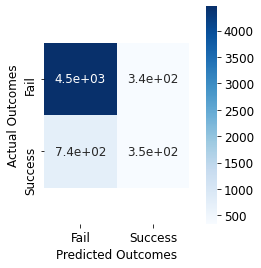

<Figure size 432x288 with 0 Axes>

In [319]:
lr_confusion = confusion_matrix(y_sel_test, [
    1 if item[1] > 0.35 else 0
    for item in lr_tuned.predict_proba(X_sel_test_scaled)
])

sns.heatmap(lr_confusion,
            cmap=plt.cm.Blues,
            annot=True,
            square=True,
            xticklabels=['Fail', 'Success'],
            yticklabels=['Fail', 'Success'])  
b, t = plt.ylim()  # descobrir os valores para baixo e para cima
b += 0.5  # Adicionar 0,5 aos de baixo
t -= 0.5  # Subtrair 0,5 do topo
plt.ylim(b, t)  # Atualizar os valores de ylim(inferior, superior)
plt.xlabel('Predicted Outcomes')
plt.ylabel('Actual Outcomes')
plt.show()
plt.savefig('/home/lucas/startup_data/confusion.png')